# Eigenfaces

### import packages

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import glob
from time import perf_counter
from tqdm import notebook

from rputil import *

%matplotlib inline

### load data

In [2]:
m = 187500
n = 620

data = np.empty((m, n)) # images are 250x250x3

for i,filename in enumerate(glob.iglob('lfw/**/*.jpg', recursive = True)):
    if i >= n:
        break
    im=Image.open(filename)
    data[:,i] = np.asarray(im).flatten()
    im.close()

In [3]:
data /= 255

In [4]:
specific_image = np.copy(data[:,0])

#### column-center the data

In [5]:
data_mean = np.expand_dims(np.mean(data, axis=1),1)
data -= data_mean

### define factorization functions

In [6]:
start = perf_counter()
det_U,_,_ = np.linalg.svd(data, full_matrices=False)
end = perf_counter()
det_time = end - start

def svd_rank_k(k):
    return det_U[:,:k]

In [11]:
# based on algorithms 4.1 (page 22) and 5.1 (page 29) of halko
# note that we are assuming Q has real entries in this implementation
def rsvd_rank_k(k, p=5):
    if p < 0:
        raise ValueError
    l = k + p
    
    # Stage A
    omega = random.randn(n, l) # n x l
    Y = data @ omega # m x l
    Q, R = np.linalg.qr(Y) # m x l, l x l
    
    # Stage B
    B = Q.T @ data # l x n
    U_tilde,_,_ = np.linalg.svd(B, full_matrices=False)
    U = Q @ U_tilde # m x r

    return U[:,:k]

### calculate eigenfaces

In [12]:
k = 350

In [13]:
det_basis = svd_rank_k(k)
print(det_basis.shape)

(187500, 350)


In [14]:
rand_basis = rsvd_rank_k(k)
print(rand_basis.shape)

(187500, 350)


In [15]:
def normalize_basis(basis):
    return (basis - np.min(basis))/(np.max(basis)-np.min(basis))

In [16]:
normalized_det_basis = normalize_basis(det_basis)

In [17]:
normalized_rand_basis = normalize_basis(rand_basis)

In [18]:
def plot_eigenfaces(basis, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(15, 15 / cols * rows))
    for i in range(rows):
        for j in range(cols):
            ax[i][j].imshow(basis[:,i * cols + j].reshape(250,250,3))

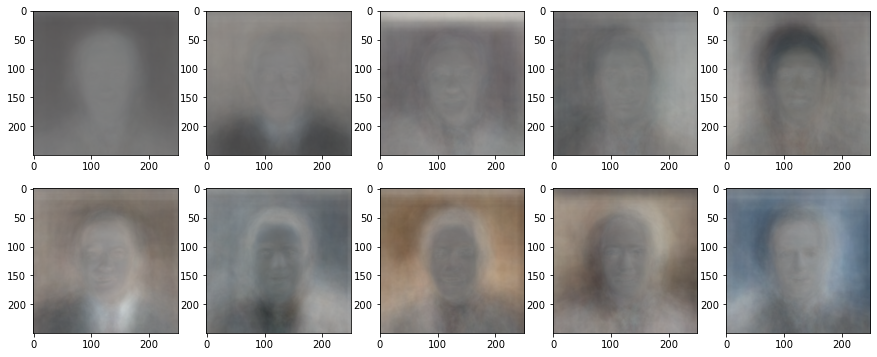

In [19]:
plot_eigenfaces(normalized_det_basis, 2, 5)

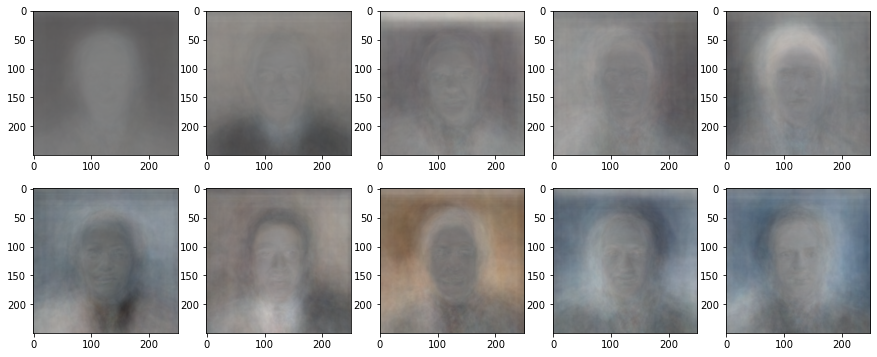

In [20]:
plot_eigenfaces(normalized_rand_basis, 2, 5)

### reconstruct an image 

In [21]:
det_coefficients = (specific_image - np.squeeze(data_mean)) @ det_basis

In [22]:
rand_coefficients = (specific_image - np.squeeze(data_mean)) @ rand_basis

In [23]:
det_reconstructed_image = np.squeeze(data_mean) + (det_basis @ det_coefficients)

In [24]:
rand_reconstructed_image = np.squeeze(data_mean) + (rand_basis @ rand_coefficients)

In [25]:
# d = 5
# reconstructed_image = np.squeeze(data_mean) + (det_basis[:,:d] @ coefficients[:d])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


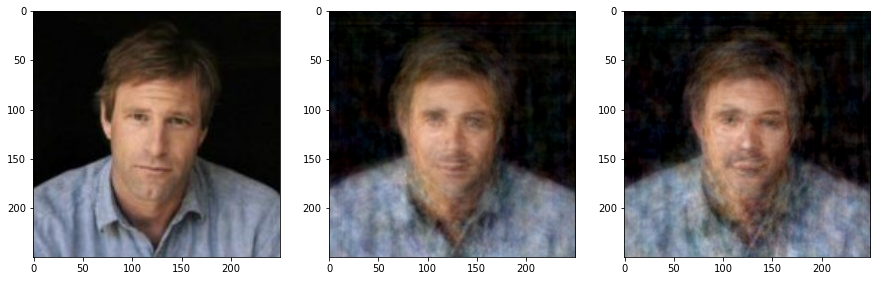

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(15,10))
ax[0].imshow(specific_image.reshape(250,250,3))
ax[1].imshow(det_reconstructed_image.reshape(250,250,3))
ax[2].imshow(rand_reconstructed_image.reshape(250,250,3))

### evaluate performance

In [27]:
domain = np.arange(50, 500, step=50)

rand_times = []
errors = []

for k in domain:
    print(f'Computing RSVD with rank k={k}...')
    
    det_basis = svd_rank_k(k)
    
    start = perf_counter()
    rand_basis = rsvd_rank_k(k)
    end = perf_counter()
    rand_time = end - start
    
    rand_times.append(rand_time / det_time)
    
    # sketchy fix for negative basis vectors
    for i in range(n):
        if np.dot(det_basis[:,i], rand_basis[:,i]) < 0:
            rand_basis[:,i] *= -1
    
    error = np.linalg.norm(rand_basis - det_basis) / np.linalg.norm(det_basis)
    errors.append(error)

Computing RSVD with rank k=50...
Computing RSVD with rank k=100...
Computing RSVD with rank k=150...
Computing RSVD with rank k=200...
Computing RSVD with rank k=250...
Computing RSVD with rank k=300...
Computing RSVD with rank k=350...
Computing RSVD with rank k=400...
Computing RSVD with rank k=450...


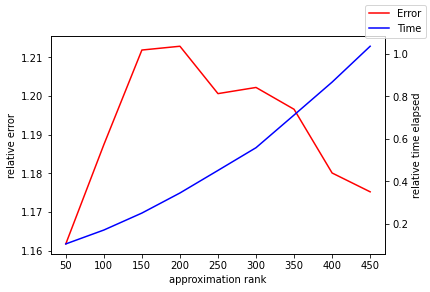

In [28]:
fig, ax = plt.subplots()

ax.set_xlabel('approximation rank')

ax.plot(domain, errors, c='r', label='Error')
ax.set_ylabel('relative error')

ax2 = ax.twinx()

ax2.plot(domain, rand_times, c='b', label='Time')
ax2.set_ylabel('relative time elapsed')

fig.legend(loc='upper right')

In [29]:
errors

[1.161723106658728,
 1.1874172542176706,
 1.2119177476124632,
 1.2129002190175502,
 1.2006336613653728,
 1.2022305156877695,
 1.1965778116552626,
 1.1800851374666517,
 1.1752112752665602]

In [31]:
np.linalg.norm(rand_basis - det_basis)

24.929995862036304

In [32]:
np.linalg.norm(det_basis)

21.21320343559647

In [39]:
rand_basis-det_basis

array([[ 4.71216468e-05,  6.10231816e-05, -6.43693485e-05, ...,
        -5.50918715e-04, -5.09874812e-03,  7.74223562e-03],
       [ 4.61713856e-05,  7.79526153e-05, -1.08927141e-04, ...,
        -1.11321130e-03, -6.12094630e-04,  3.29446725e-03],
       [ 3.49046622e-05,  8.49736197e-05, -1.32937251e-04, ...,
        -6.07847563e-04,  2.70165844e-03,  3.19110608e-03],
       ...,
       [-2.49544544e-05, -3.01123103e-05, -1.67250618e-04, ...,
        -7.79857684e-03, -3.33579736e-03,  5.22528935e-04],
       [-6.19849871e-05, -6.42794804e-05, -7.82418249e-05, ...,
        -5.32915490e-03, -9.04942343e-03,  1.21814980e-03],
       [-7.04264296e-05, -9.35043215e-05, -7.46641030e-06, ...,
        -1.01444190e-02, -9.25936155e-03,  6.40209122e-03]])

In [34]:
det_basis

array([[-0.00209607,  0.00106501,  0.00652978, ...,  0.00297317,
         0.00531473, -0.00363808],
       [-0.00213111,  0.00101366,  0.00630916, ...,  0.00470764,
         0.00236994, -0.00148765],
       [-0.00207876,  0.00092914,  0.00593012, ...,  0.00447443,
         0.00046395,  0.00025502],
       ...,
       [-0.00077706, -0.00473097,  0.00192389, ..., -0.00534476,
         0.00073853, -0.00398285],
       [-0.00080359, -0.00452439,  0.00201785, ..., -0.00377036,
         0.00457226, -0.00222872],
       [-0.00084918, -0.0044254 ,  0.00174733, ..., -0.00109816,
         0.00459634, -0.00526456]])